### Load up the data and format it

In [27]:
import pandas as pd
from dateutil import parser
from datetime import datetime # for converting and using dates
import pytz
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
articles = pd.read_csv("../../data/processed/gbh_geocoded_output.csv")
demographics = pd.read_csv("../../data/processed/demographics_by_tract.csv")

# Drop unnecessary columns
demographics = demographics.drop(columns=["Index", "Name", "State", "County"])

# Drop rows without neighborhoods
articles.dropna(subset=["Neighborhood"], inplace=True)

# Dictionary to map timezone names to pytz time zones
tzinfos = {'EST': pytz.timezone('US/Eastern'), 'EDT': pytz.timezone('US/Eastern')}

# Function to convert date strings to datetime objects
def convert_to_datetime(date_str):
    return parser.parse(date_str, tzinfos=tzinfos)

# Apply the conversion function to the 'Publication Date' column
articles['Publication Date'] = articles['Publication Date'].apply(convert_to_datetime)

# Ensure the Publication Date column is timezone-aware
articles['Publication Date'] = articles['Publication Date'].dt.tz_convert(pytz.timezone('US/Eastern'))


### Filter on the appropriate month

In [29]:
# Define the date range (example)
start_date = pytz.timezone('US/Eastern').localize(datetime(2023, 3, 1)) # This is the month with most published articles on the given data set
end_date = pytz.timezone('US/Eastern').localize(datetime(2023, 4, 1))

# Filter the DataFrame for the date range
filtered_articles = articles[(articles['Publication Date'] >= start_date) & (articles['Publication Date'] <= end_date)]

print(f"Using articles from {start_date.date()} to {end_date.date()}")

Using articles from 2023-03-01 to 2023-04-01


### Include demographics data

In [30]:
# Function to merge articles with demographics
def merge_articles_with_demographics(articles_df, demographics_df):
    merged_df = pd.merge(articles_df, demographics_df, on='Census Tract', how='left')
    return merged_df

merged_articles = merge_articles_with_demographics(filtered_articles, demographics)

In [31]:
# Define Boston demographics for normalization
boston_demographics = {"White": 0.5985, "African American": 0.2771, "Asian": 0.1195, "American Indian and Alaska Native": 0.003695, "Native Hawaiian and Other Pacific Island": 0.001232, "Other": 0}
boston_demographics_df = pd.DataFrame(list(boston_demographics.items()), columns=['Race', 'Population'])
boston_demographics_df = boston_demographics_df.reset_index(drop=True)
boston_demographics_df["Population"] = round(boston_demographics_df["Population"]*100, 2)


### Label Census Tracts by Predominant Race

In [32]:
# Identify predominant race for each census tract
merged_articles['Predominant Race'] = merged_articles[['White', 'African American', 'American Indian and Alaska Native', 'Asian', 'Native Hawaiian and Other Pacific Island', 'Other']].idxmax(axis=1)


In [40]:
# Count Census Tracts labeled as each race 
merged_articles["Predominant Race"].value_counts()

Predominant Race
White               91
African American     4
Asian                3
Name: count, dtype: int64

In [33]:
# Function to get article and topic counts, and topic distribution for a given race
def get_race_stats(df, race):
    race_df = df[df['Predominant Race'] == race]
    topic_distribution = race_df['Closest Topic'].value_counts()
    article_count = len(race_df)
    total_articles = len(df)
    topic_count = len(topic_distribution)
    percent_articles = article_count / total_articles * 100
    topic_percent = topic_distribution / total_articles* 100
    
    return {
        "Topic Distribution": topic_distribution,
        "Topic Count": topic_count,
        "Article Count": article_count,
        "Percent of Total Articles": percent_articles,
        "Topic Percent": topic_percent
    }

# Overall Boston statistics
def get_boston_stats(df):
    topic_distribution = df["Closest Topic"].value_counts()
    article_count = len(df)
    topic_count = len(topic_distribution)
    
    return {
        "Topic Distribution": topic_distribution,
        "Topic Count": topic_count,
        "Article Count": article_count
    }

# Compare race stats to Boston stats
def compare_race_to_boston(race_stats, boston_stats):
    comparison = {
        "Race Article %": race_stats["Percent of Total Articles"],
        "Race Topic %": race_stats["Topic Percent"],
        "Boston Topic %": (boston_stats["Topic Distribution"] / boston_stats["Article Count"] * 100)
    }
    
    return comparison

# Get relevant census tracts and neighborhoods for a given race
def get_relevant_census_tracts(df, race):
    census_tracts = df[df["Predominant Race"] == race]["Census Tract"].value_counts()
    neighborhoods = df[df["Predominant Race"] == race]["Neighborhood"].value_counts()
    
    return {
        "Census Tracts": census_tracts,
        "Neighborhoods": neighborhoods
    }

In [34]:
# Get Boston stats
boston_stats = get_boston_stats(merged_articles)

# Example race analysis
race = "White"  # Check with relevant race
race_stats = get_race_stats(merged_articles, race)

# Compare race stats to Boston stats
comparison = compare_race_to_boston(race_stats, boston_stats)

# Get relevant census tracts and neighborhoods for the given race
relevant_stats = get_relevant_census_tracts(merged_articles, race)

# Display relevant census tracts and neighborhoods
print(f"Top Census Tracts for {race}:\n", relevant_stats["Census Tracts"].head())
print(f"Top Neighborhoods for {race}:\n", relevant_stats["Neighborhoods"].head())
print(f"Topic count {race_stats["Topic Count"]}")
print(f"Top 5 topics {race_stats["Topic Distribution"].head(5)}")
print(f"Article count {race_stats["Article Count"]}")  


Top Census Tracts for White:
 Census Tract
30302    36
20302    11
10103     7
10600     6
71201     3
Name: count, dtype: int64
Top Neighborhoods for White:
 Neighborhood
Downtown       42
Beacon Hill    12
Fenway         11
Back Bay        8
East Boston     3
Name: count, dtype: int64
Topic count 30
Top 5 topics Closest Topic
Local Politics          14
Other                   14
Politics/Elections      10
Housing/Homelessness     8
Labor/Workforce          4
Name: count, dtype: int64
Article count 91


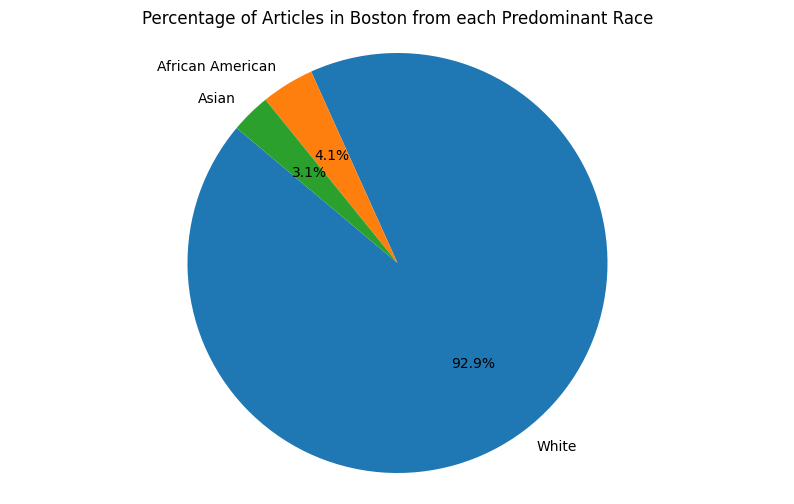

In [35]:
# Visualize the percentage of articles in Boston that come from census tracts with each predominant race
# List of main races
races = ['White', 'African American', 'Asian']

# Calculate the percentage of articles for each race
race_article_percentages = {}
total_articles = len(merged_articles)

for race_ in races:
    race_article_count = len(merged_articles[merged_articles['Predominant Race'] == race_])
    race_article_percentages[race_] = (race_article_count / total_articles) * 100

# Prepare data for the pie chart
labels = list(race_article_percentages.keys())
sizes = list(race_article_percentages.values())

# Plot the pie chart
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Percentage of Articles in Boston from each Predominant Race")
plt.axis('equal')
plt.show()

C:\Users\axel0\AppData\Local\Temp\ipykernel_29888\3108354406.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=race_stats["Topic Distribution"].values, y=race_stats["Topic Distribution"].index, palette="viridis")


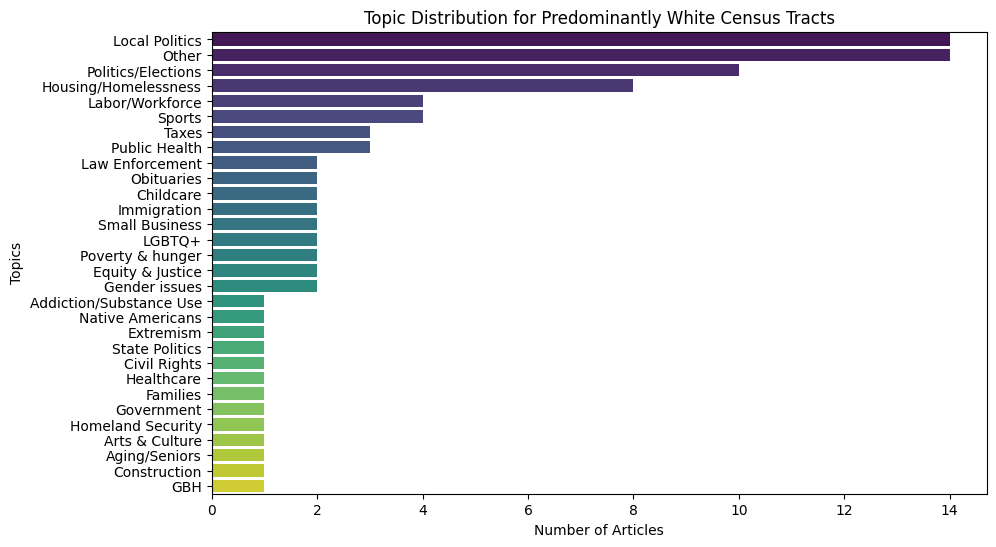

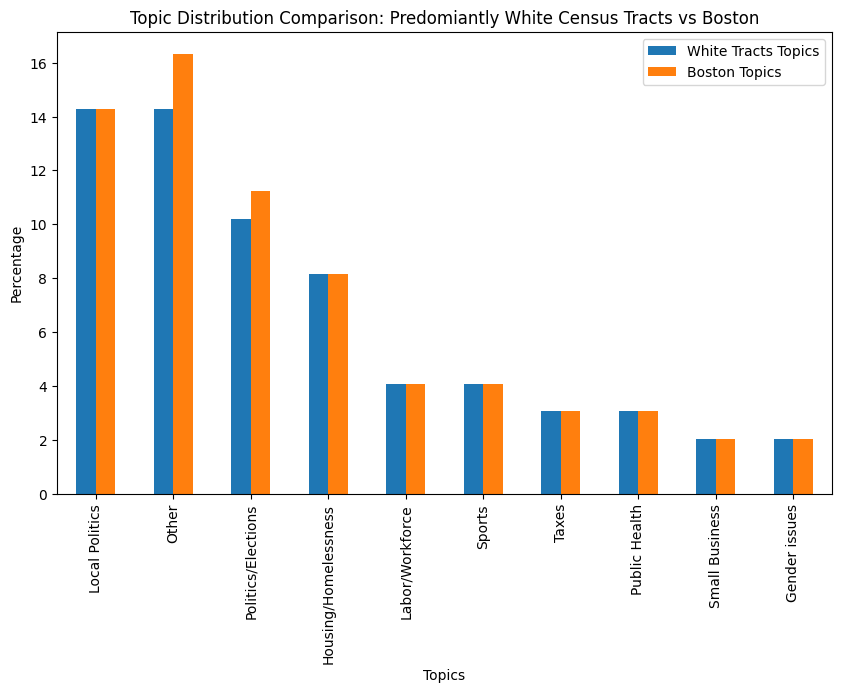

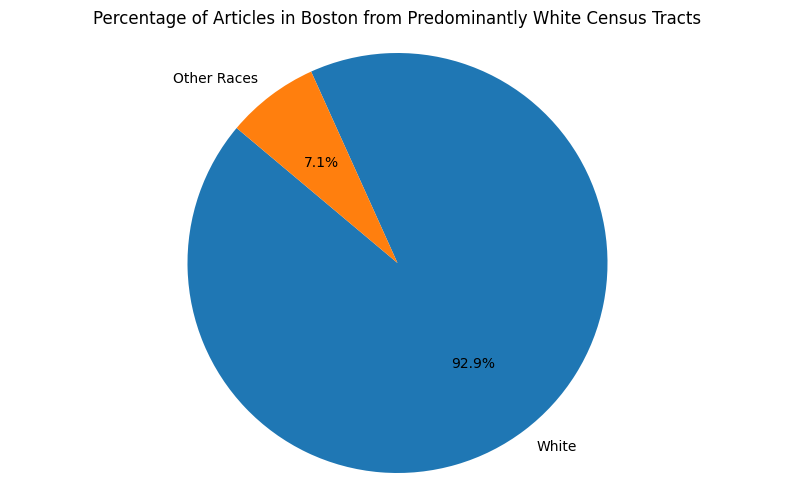

In [36]:
# Visualize topic distribution for the given race
plt.figure(figsize=(10, 6))
sns.barplot(x=race_stats["Topic Distribution"].values, y=race_stats["Topic Distribution"].index, palette="viridis")
plt.xlabel("Number of Articles")
plt.ylabel("Topics")
plt.title(f"Topic Distribution for Predominantly {race} Census Tracts")
plt.show()

# Visualize comparison of topic distribution
top_race_topics = comparison["Race Topic %"].sort_values(ascending=False).head(10)
boston_topics_filtered = comparison["Boston Topic %"].reindex(top_race_topics.index)

comparison_df = pd.DataFrame({
    f"{race} Tracts Topics": top_race_topics,
    "Boston Topics": boston_topics_filtered
})

comparison_df.plot(kind='bar', figsize=(10, 6))
plt.xlabel("Topics")
plt.ylabel("Percentage")
plt.title(f"Topic Distribution Comparison: Predomiantly {race} Census Tracts vs Boston")
plt.show()



# Visualize the percentage of articles in Boston that come from census tracts with the predominant race
race_article_percentage = race_stats["Percent of Total Articles"]
plt.figure(figsize=(10, 6))
plt.pie([race_article_percentage, 100 - race_article_percentage], labels=[race, "Other Races"], autopct='%1.1f%%', startangle=140)
plt.title(f"Percentage of Articles in Boston from Predominantly {race} Census Tracts")
plt.axis('equal') 
plt.show()